In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

### Part 1

In [2]:
data_red = pd.read_csv("winequality-red.csv",delimiter=";")
X = data_red.drop('quality', axis=1)
y = data_red['quality']

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
model.score(x_test, y_test)

0.575

Multi-class classification using Logistic regression gives us the better results, as in this case, this approach handels irregularities in the data by establishing decision boundaries between classes. 
In Linear regression we may have  inflated R² values when the target is discrete and rounded, as the model captures noise or small fluctuations that don’t reflect the true nature of the data. On the other hand, multi-class classification directly aligns with the nature of the problem (discrete wine quality scores), leading to more accurate performance metrics and avoids the misleading effect of R². 


Logistic Regression may fail to capture complex patterns in the data. Also, if features are highly correlated, Logistic Regression might lead to unstable coefficients and overfitting, affecting the model’s generalization ability.

Even though treating quality as a discrete label ignores the fact that wine quality ratings are ordinal and continuous in nature.


### Part 2

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
label = pd.read_csv("test_label.csv")

In [5]:
train.describe()

,ID,age,balance,day,campaign,pdays,previous
count,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000
mean,16434.500000,41.091142,1483.774437,15.641103,2.659130,45.555478,0.688967
std,3715.393317,11.305560,3311.055181,8.368983,2.863507,104.449411,2.049696
min,10000.000000,18.000000,-6847.000000,1.000000,1.000000,-1.000000,0.000000
25%,13217.250000,32.000000,102.000000,8.000000,1.000000,-1.000000,0.000000
50%,16434.500000,39.000000,515.000000,16.000000,2.000000,-1.000000,0.000000
75%,19651.750000,49.000000,1591.750000,21.000000,3.000000,-1.000000,0.000000
max,22869.000000,95.000000,102127.000000,31.000000,43.000000,854.000000,58.000000


In [6]:
train.head(3)

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,13829,29,technician,single,tertiary,no,18254,no,no,cellular,11,may,2,-1,0,unknown,no
1,22677,26,services,single,secondary,no,512,yes,yes,unknown,5,jun,3,-1,0,unknown,no
2,10541,30,management,single,secondary,no,135,no,no,cellular,14,aug,2,-1,0,unknown,no


In [7]:
train["job"].unique()

array(['technician', 'services', 'management', 'admin.', 'student',
       'blue-collar', 'housemaid', 'retired', 'unemployed',
       'self-employed', 'unknown', 'entrepreneur'], dtype=object)

In [8]:
train.isnull().sum()

ID           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [9]:
train.dtypes

ID            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [10]:
object_columns = train.select_dtypes(include=['object'])
for col in object_columns.columns:
    print(f"{col}  categories: {object_columns[col].unique()}")


job  categories: ['technician' 'services' 'management' 'admin.' 'student' 'blue-collar'
 'housemaid' 'retired' 'unemployed' 'self-employed' 'unknown'
 'entrepreneur']
marital  categories: ['single' 'married' 'divorced']
education  categories: ['tertiary' 'secondary' 'unknown' 'primary']
default  categories: ['no' 'yes']
housing  categories: ['no' 'yes']
loan  categories: ['no' 'yes']
contact  categories: ['cellular' 'unknown' 'telephone']
month  categories: ['may' 'jun' 'aug' 'jul' 'sep' 'nov' 'mar' 'apr' 'jan' 'feb' 'oct' 'dec']
poutcome  categories: ['unknown' 'failure' 'other' 'success']
y  categories: ['no' 'yes']


In [11]:
X_train = train.drop("y", axis = 1)
X_test = test

y_train = train["y"]
y_test = label["y"]


In [12]:
assert X_train.columns.all() == X_test.columns.all()

class DummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.get_dummies(X, columns=X.select_dtypes(include=['object']).columns, drop_first=True)  

pipeline = Pipeline(steps=[('dummies', DummiesTransformer())])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)


print(X_train.shape)  
print(X_test.shape)  

(12870, 42)
(4291, 42)


In [13]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler_type='none'):
        self.scaler_type = scaler_type
        if self.scaler_type == 'standard':
            self.scaler = StandardScaler()
        elif self.scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.scaler_type == 'none':
            self.scaler = None  
        else:
            raise ValueError("Invalid scaler type! Choose 'standard', 'minmax', or 'none'.")
    
    def fit(self, X, y=None):
        if self.scaler is not None:
            self.scaler.fit(X)
        return self
    
    def transform(self, X):
        if self.scaler is None:
            return np.ascontiguousarray(X)
        return self.scaler.transform(X)
    

In [14]:
def evaluation_metrics(model, name):
    global X_train, X_test,y_train, y_test
        
    print(f"Evaluation Metrics for {name}\n")
    
    print(f"Train Accuracy: {model.score(X_train, y_train)}")
    print(f"Test Accuracy: {model.score(X_test, y_test)}")

    y_pred = model.predict(X_test)
    macro_precision = precision_score(y_test, y_pred, average='macro')
    micro_precision = precision_score(y_test, y_pred, average='micro')

    macro_recall = recall_score(y_test, y_pred, average='macro')
    micro_recall = recall_score(y_test, y_pred, average='micro')

    f1_standard = f1_score(y_test, y_pred, average='weighted')

    print(f"Macro-Averaged Precision: {macro_precision}")
    print(f"Micro-Averaged Precision: {micro_precision}")
    print(f"Macro-Averaged Recall: {macro_recall}")
    print(f"Micro-Averaged Recall: {micro_recall}")
    print(f"F1 Score: {f1_standard}")



## Linear SVC

In [63]:
pipe_svc = Pipeline([
    ('scaler', CustomScaler(scaler_type='none')),
    ('svc', LinearSVC(dual=True, random_state=42, max_iter=5000))
])

param_grid_svc = {'svc__C': [0.1, 1, 10, 100, 1000], 'svc__max_iter': [5000]} 

gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='accuracy',  return_train_score=True)
gs_svc.fit(X_train, y_train)

svc_model = gs_svc.best_estimator_

/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242

In [79]:
print(f"Best Parameters: {gs_svc.best_params_}")

Best Parameters: {'svc__C': 0.1, 'svc__max_iter': 5000}


In [80]:
# Score report
evaluation_metrics(svc_model, "Lineaer SVC Unscaled")

Evaluation Metrics for Lineaer SVC Unscaled

Train Accuracy: 0.6860916860916861
Test Accuracy: 0.6891167560009321
Macro-Averaged Precision: 0.44570358229922735
Micro-Averaged Precision: 0.6891167560009321
Macro-Averaged Recall: 0.49881834936807934
Micro-Averaged Recall: 0.6891167560009321
F1 Score: 0.5662619954501409


In [65]:
pipe_svc_standard = Pipeline([
    ('scaler', CustomScaler(scaler_type='standard')),
    ('svc', LinearSVC(dual=True, random_state=42, max_iter=5000))
])

gs_svc_standard = GridSearchCV(pipe_svc_standard, param_grid_svc, cv=5, scoring='accuracy',  return_train_score=True)
gs_svc_standard.fit(X_train, y_train)

svc_standard_model = gs_svc_standard.best_estimator_

/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242

In [81]:
print(f"Best Parameters: {gs_svc_standard.best_params_}")

Best Parameters: {'svc__C': 1, 'svc__max_iter': 5000}


In [82]:
# Score report
evaluation_metrics(svc_standard_model, "Lineaer SVC Scaled")

Evaluation Metrics for Lineaer SVC Scaled

Train Accuracy: 0.7696969696969697
Test Accuracy: 0.7811698904684223
Macro-Averaged Precision: 0.7719077796373822
Micro-Averaged Precision: 0.7811698904684223
Macro-Averaged Recall: 0.6826217102698637
Micro-Averaged Recall: 0.7811698904684223
F1 Score: 0.7602122191747401


The Linear SVC model shows good performance with a train accuracy of 77% and test accuracy of 78%, indicating it generalizes well. The macro-averaged recall is lower at 68%, suggesting room for improvement in identifying all relevant instances. The F1 score of 0.76 indicates a solid balance between precision and recall, with potential improvements in recall for minority classes.

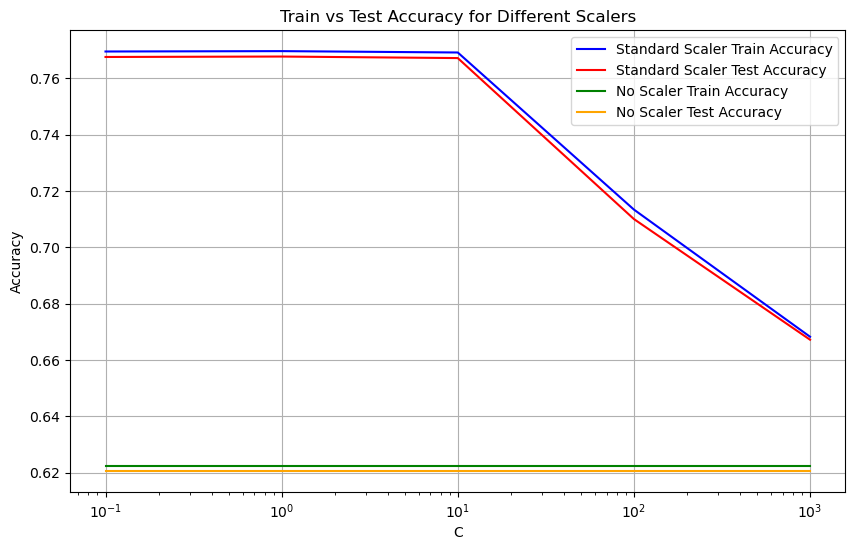

In [83]:
results_standard = gs_svc_standard.cv_results_
results_none = gs_svc.cv_results_

C_values = param_grid_svc['svc__C']


mean_train_scores_standard = results_standard['mean_train_score']
mean_test_scores_standard = results_standard['mean_test_score']

mean_train_scores_none = results_none['mean_train_score']
mean_test_scores_none = results_none['mean_test_score']


plt.figure(figsize=(10, 6))
plt.plot(C_values, mean_train_scores_standard, label='Standard Scaler Train Accuracy', color='b')
plt.plot(C_values, mean_test_scores_standard, label='Standard Scaler Test Accuracy', color='r')
plt.plot(C_values, mean_train_scores_none, label='No Scaler Train Accuracy', color='g')
plt.plot(C_values, mean_test_scores_none, label='No Scaler Test Accuracy', color='orange')
plt.xscale('log')  
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Different Scalers')
plt.legend()
plt.grid(True)
plt.show()

Observations:
    
The effect of scaling and the regularization parameter C on model performance reveals that scaling improves 
model accuracy. As C increases in scaled data, the model becomes more sensitive to noise, leading to a decrease 
in accuracy. In contrast, unscaled data is unaffected by changes in C, suggesting that scaling plays a crucial role in regularization.

#
## LogisticRegression classifier

In [84]:
pipe_logistic = Pipeline([
    ('scaler', CustomScaler(scaler_type='none')),  
    ('logistic', LogisticRegression(random_state=42, max_iter=5000))
])

param_grid_logistic = {'logistic__C': [0.1, 1, 10, 100, 1000], 'logistic__max_iter': [5000]}


gs_logistic = GridSearchCV(pipe_logistic, param_grid_logistic, cv=3, scoring='accuracy', return_train_score=True)
gs_logistic.fit(X_train, y_train)


logistic_model = gs_logistic.best_estimator_


print(f"Best Parameters: {gs_logistic.best_params_}")

Best Parameters: {'logistic__C': 0.1, 'logistic__max_iter': 5000}


In [85]:
evaluation_metrics(logistic_model, "Logistic Regression Unscaled")

Evaluation Metrics for Logistic Regression Unscaled

Train Accuracy: 0.7425796425796426
Test Accuracy: 0.729899790258681
Macro-Averaged Precision: 0.6818958060868795
Micro-Averaged Precision: 0.729899790258681
Macro-Averaged Recall: 0.6778826237229995
Micro-Averaged Recall: 0.729899790258681
F1 Score: 0.7283936134593477


In [88]:
pipe_logistic_standard = Pipeline([
    ('scaler', CustomScaler(scaler_type='standard')),  
    ('logistic', LogisticRegression(random_state=42, max_iter=5000))
])

gs_logistic_standard = GridSearchCV(pipe_logistic_standard, param_grid_logistic, cv=3, scoring='accuracy', return_train_score=True)
gs_logistic_standard.fit(X_train, y_train)


logistic_model_standard = gs_logistic_standard.best_estimator_

print(f"Best Parameters: {gs_logistic_standard.best_params_}")

Best Parameters: {'logistic__C': 10, 'logistic__max_iter': 5000}


In [89]:
evaluation_metrics(gs_logistic_standard, "Logistic Regression Scaled")

Evaluation Metrics for Logistic Regression Scaled

Train Accuracy: 0.7749028749028749
Test Accuracy: 0.7783733395478909
Macro-Averaged Precision: 0.7576067997259929
Micro-Averaged Precision: 0.7783733395478909
Macro-Averaged Recall: 0.688363722153631
Micro-Averaged Recall: 0.7783733395478909
F1 Score: 0.7614703401864193


Scaling enhances Logistic Regression performance by improving both precision and recall, leading to better generalization. The scaled model shows a more balanced approach, handling minority class predictions better and improving overall accuracy, particularly in the test set. The unscaled model struggles to capture class patterns effectively, resulting in lower scores across metrics. Scaling provides a clear advantage, especially in terms of recall and the overall F1 score, making it a better choice for this model.

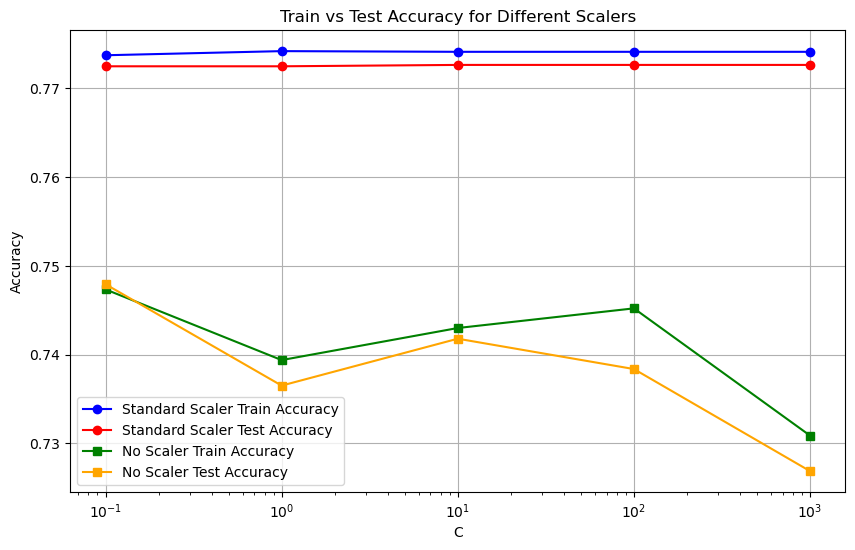

In [90]:
logistic_results_standard = gs_logistic_standard.cv_results_
logistic_results_none = gs_logistic.cv_results_

C_values = param_grid_logistic['logistic__C']


mean_train_scores_standard = logistic_results_standard['mean_train_score']
mean_test_scores_standard = logistic_results_standard['mean_test_score']


mean_train_scores_none = logistic_results_none['mean_train_score']
mean_test_scores_none = logistic_results_none['mean_test_score']


plt.figure(figsize=(10, 6))
plt.plot(C_values, mean_train_scores_standard, label='Standard Scaler Train Accuracy', color='b', marker='o')
plt.plot(C_values, mean_test_scores_standard, label='Standard Scaler Test Accuracy', color='r', marker='o')
plt.plot(C_values, mean_train_scores_none, label='No Scaler Train Accuracy', color='g', marker='s')
plt.plot(C_values, mean_test_scores_none, label='No Scaler Test Accuracy', color='orange', marker='s')
plt.xscale('log')  
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Different Scalers')
plt.legend()
plt.grid(True)
plt.show()

The value of C has a diminished effect on scaled datasets compared to unscaled ones. This is because scaling the 
features often serves as a form of implicit regularization. By normalizing the features, we reduce the model's 
ability to fit noise in the data, which can make the impact of C less pronounced. On the other hand, when using 
unscaled data, the model tends to perform much worse, and the effect of C becomes more noticeable. As the value of 
C increases, the model is less regularized, leading to overfitting. This results in a decrease in test scores,
as the model starts to fit the noise rather than generalize well to unseen data.


#
## KNeighborsClassifier

In [91]:
pipe_knn = Pipeline([
    ('scaler', CustomScaler(scaler_type='none')),  
    ('knn', KNeighborsClassifier())
])
param_grid_knn = { 'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15,17,19,21,23,25,27,29,31,33]}


gs_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=3, scoring='accuracy', return_train_score=True)
gs_knn.fit(X_train, y_train)


knn_model = gs_knn.best_estimator_

print(f"Best Parameters: {gs_knn.best_params_}\n")
evaluation_metrics(knn_model,"K-Nearest Neighbors Unscaled Model" )

Best Parameters: {'knn__n_neighbors': 33}

Evaluation Metrics for K-Nearest Neighbors Unscaled Model

Train Accuracy: 0.694017094017094
Test Accuracy: 0.6919133069214636
Macro-Averaged Precision: 0.3459566534607318
Micro-Averaged Precision: 0.6919133069214636
Macro-Averaged Recall: 0.5
Micro-Averaged Recall: 0.6919133069214636
F1 Score: 0.5659202777547728


/Users/saikodze/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
pipe_knn_standard = Pipeline([
    ('scaler', CustomScaler(scaler_type='standard')),  
    ('knn', KNeighborsClassifier())
])


gs_knn_standard = GridSearchCV(pipe_knn_standard, param_grid_knn, cv=3, scoring='accuracy', return_train_score=True)
gs_knn_standard.fit(X_train, y_train)


knn_model_standard = gs_knn_standard.best_estimator_


print(f"Best Parameters: {gs_knn_standard.best_params_}\n")
evaluation_metrics(knn_model_standard,"K-Nearest Neighbors Scaled Model" )

Best Parameters: {'knn__n_neighbors': 23}

Evaluation Metrics for K-Nearest Neighbors Scaled Model

Train Accuracy: 0.7794094794094794
Test Accuracy: 0.7636914472151014
Macro-Averaged Precision: 0.7429429607720375
Micro-Averaged Precision: 0.7636914472151014
Macro-Averaged Recall: 0.6605498369689006
Micro-Averaged Recall: 0.7636914472151014
F1 Score: 0.7402001118549362


Scaling provides a substantial improvement for the K-Nearest Neighbors model. The scaled model shows much better performance in terms of both accuracy and F1 score, with improved precision and recall. The unscaled model struggles with classifying the data, especially the minority classes, while the scaled model achieves better generalization and a more balanced classification performance.

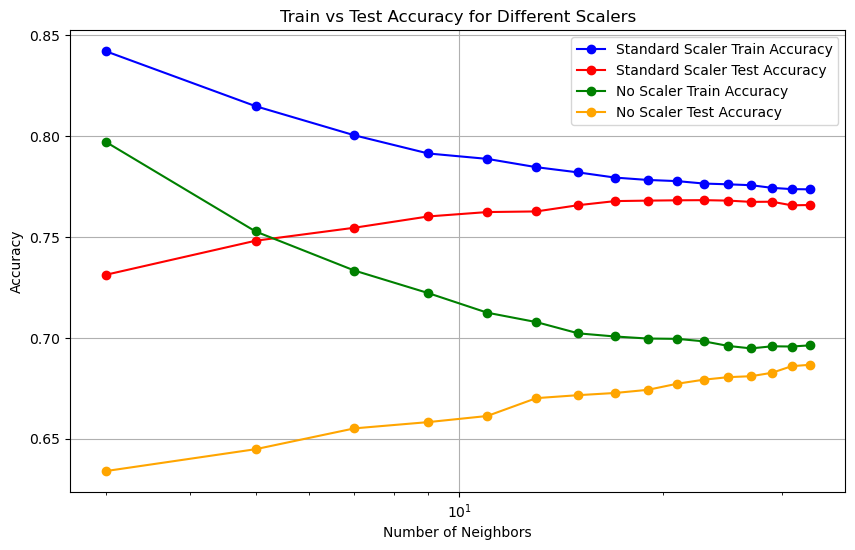

In [93]:
knn_results_standard = gs_knn_standard.cv_results_
knn_results_none = gs_knn.cv_results_

Nei = param_grid_knn['knn__n_neighbors']


mean_train_scores_standard = knn_results_standard['mean_train_score']
mean_test_scores_standard = knn_results_standard['mean_test_score']


mean_train_scores_none = knn_results_none['mean_train_score']
mean_test_scores_none = knn_results_none['mean_test_score']


plt.figure(figsize=(10, 6))
plt.plot(Nei, mean_train_scores_standard, label='Standard Scaler Train Accuracy', color='b', marker='o')
plt.plot(Nei, mean_test_scores_standard, label='Standard Scaler Test Accuracy', color='r', marker='o')
plt.plot(Nei, mean_train_scores_none, label='No Scaler Train Accuracy', color='g', marker='o')
plt.plot(Nei, mean_test_scores_none, label='No Scaler Test Accuracy', color='orange', marker='o')
plt.xscale('log')  
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Different Scalers')
plt.legend()
plt.grid(True)
plt.show()

Scaling the data consistently results in higher accuracy for both training and testing datasets. Notably, the margin
between training and testing accuracy is smaller with scaled data, indicating a more balanced model. For the
unscaled dataset, the accuracy increases as the number of neighbors increases, suggesting that a larger 
neighborhood is beneficial for the model. In contrast, with the scaled data, the maximum accuracy is achieved 
with fewer neighbors, showing that scaling makes the model more sensitive to smaller neighborhoods. 
This highlights the importance of preprocessing for KNN, where scaling optimizes model performance with a 
more controlled number of neighbors.    

#
## PART 2

### DecisionTreeClassifier

In [94]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

evaluation_metrics(dt_model, "Decision Tree Classifier Model")

Evaluation Metrics for Decision Tree Classifier Model

Train Accuracy: 1.0
Test Accuracy: 0.6180377534374272
Macro-Averaged Precision: 0.5733367088018251
Micro-Averaged Precision: 0.6180377534374272
Macro-Averaged Recall: 0.5802626892411703
Micro-Averaged Recall: 0.6180377534374272
F1 Score: 0.6266115859412605


The DecisionTreeClassifier is not resilient to overfitting without hyperparameter tuning, as evidenced by 
perfect train accuracy (1.0) but significantly lower test accuracy (0.618). This large gap highlights overfitting,
where the model memorizes training data but generalizes poorly to unseen data. Hyperparameter tuning is essential 
to mitigate this issue.

In [95]:
param_grid = {
    'max_depth': [2, 3, 5, 8, 10, 15, 20, 30, None],
    'max_features': [None, 'sqrt', 'log2', 0.5]  
}

grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Train Accuracy:", best_model.score(X_train, y_train))
print("Test Accuracy:", best_model.score(X_test, y_test))

Best Parameters: {'max_depth': 10, 'max_features': None}
Train Accuracy: 0.7996891996891997
Test Accuracy: 0.7711489163365183


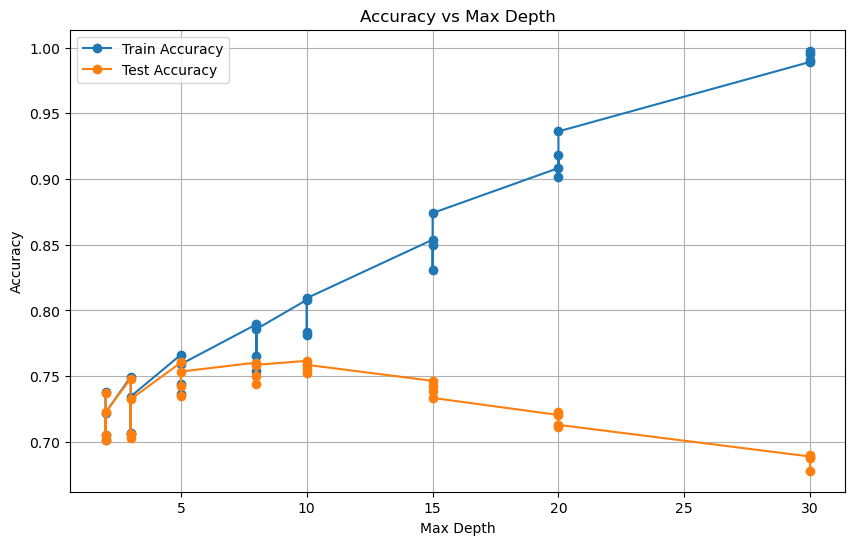

In [96]:
cv_results = grid_search.cv_results_

param_max_depth = np.array(cv_results['param_max_depth'].data, dtype=object)
mean_train_scores = cv_results['mean_train_score']
mean_test_scores = cv_results['mean_test_score']

mask = param_max_depth != 'None'
param_max_depth = param_max_depth[mask]

mean_train_scores = mean_train_scores[mask]
mean_test_scores = mean_test_scores[mask]

plt.figure(figsize=(10, 6))
plt.plot(param_max_depth, mean_train_scores, label='Train Accuracy', marker='o')
plt.plot(param_max_depth, mean_test_scores, label='Test Accuracy', marker='o')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The best max_depth=10 suggests the model benefits from a moderate tree depth, capturing enough complexity 
without excessive overfitting. Deeper trees (e.g., max_depth=15 or higher) cause the model to overfit, as seen
by the widening gap between training and test accuracy.

max_features=None indicates that all features are relevant for the decision-making process, contributing to 
the model's performance. This choice is optimal because the features are not highly correlated, and using all 
available features helps the model achieve the best accuracy without overcomplicating the model. 

#
## RandomForestClassifier

In [15]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

evaluation_metrics(rf_model, "Random Forest Classifier")

Evaluation Metrics for Random Forest Classifier

Train Accuracy: 1.0
Test Accuracy: 0.7888604054998835
Macro-Averaged Precision: 0.7676493332022675
Micro-Averaged Precision: 0.7888604054998835
Macro-Averaged Recall: 0.708110892739855
Micro-Averaged Recall: 0.7888604054998835
F1 Score: 0.775815484465038


i. Decision trees are single models that split data based on feature values. while random forests combine 
multiple trees to average predictions, making results more stable and less likely to overfit.

ii. Use decision trees for simple and clear insights, for identifying the most important features. 
Random forests work better when accuracy matters more, especially with complex or noisy data, 
where generalization is preferred.

iii. Accuracy isn’t a great evaluation metric for imbalanced datasets because it overlooks class imbalance 
and can mislead by favoring predictions for the majority class, ignoring minority class performance.

In [16]:
param_grid = {
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=True)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Train Accuracy:", best_model.score(X_train, y_train))
print("Test Accuracy:", best_model.score(X_test, y_test))


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Train Accuracy: 1.0
Test Accuracy: 0.7848986250291308


Random Forest uses multiple decision trees, which can easily overfit the training data, 
leading to a perfect train accuracy (1.0). Even after tuning parameters like max_depth or n_estimators,
the test and train scores don't change much, as the model is already well-balanced between overfitting and 
underfitting. The reason is that the model uses multiple trees with random data subsets, which helps prevent overfitting to the training data. 